In [60]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline


# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#warnings
import warnings
warnings.filterwarnings('ignore')

In [58]:
def split_data(data):
    #define X, y
    X = data.drop(['label'], axis=1).values
    y = data['label'].values
    #split into train and test to avoid overfitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
def rf_model(X_train, y_train):
    '''
    random forest model
    input: X_train, y_train
    output: random forest model
    '''
    rf = RandomForestClassifier(n_estimators=100, 
                                max_features='sqrt',
                                max_depth=15,
                                min_samples_leaf=20,
                                oob_score=True)
    rf.fit(X_train, y_train)
    return rf

In [65]:
def report(y_test, y_pred):
    print(classification_report(y_test, y_pred))

In [40]:
def get_feature_importance(data):
    '''
    input: dataframe
    output: feature importance dataframe, feature importance plot
    '''
    # a dict to hold feature_name: feature_importance
    feats = {} 
    for feature, importance in zip(data.drop(columns=['label']), rf.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(figsize=(10,6),kind='bar')
    plt.savefig('feature_importance.png')
    return importances

In [41]:
def plot_confusion_matrix(y_test, y_pred,normalize=False):
    '''
    plot confusion matrix
    input: y_test,y_pred
    output: confusion matrix plot
    '''
    cnf_matrix=metrics.confusion_matrix(y_test,y_pred)
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.savefig('confusion_matrix.png')
    

In [57]:
def plot_roc_auc(X_test,y_test, y_pred):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC.png')
    plt.show()

In [42]:
def grid_search(param,x,y):
    '''
    grid search for random forest
    with 5-fold cross validation
    '''
    model = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100,
                                                            oob_score=True,
                                                            random_state=10),                         
                        param_grid = param, 
                        scoring='roc_auc',
                        cv=5)
    model.fit(x,y)
    print(model.best_params_)
    print(model.best_score_)  
    return model

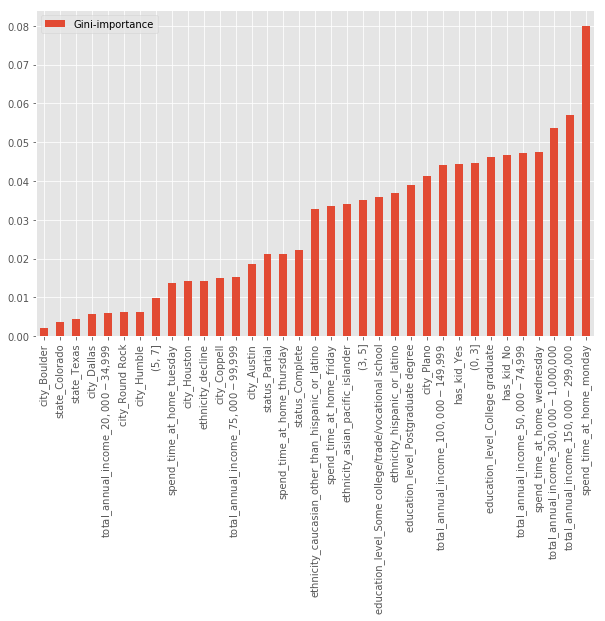

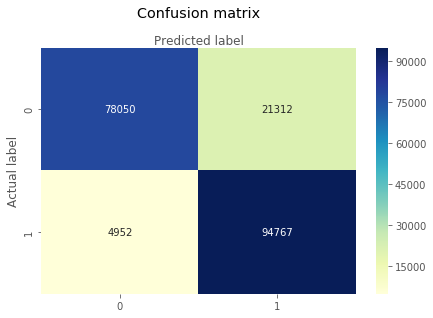

<Figure size 432x288 with 0 Axes>

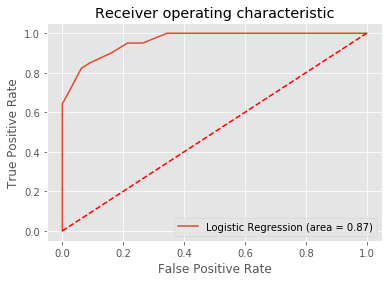

In [59]:
if __name__ == '__main__':
    #data
    data=pd.read_csv('./data/data_final.csv', index_col =0)
    X_train, X_test, y_train, y_test = split_data(data)
    #model before grid search
    rf = rf_model(X_train, y_train)
    y_pred = rf.predict(X_test)
    report(y_test, y_pred)
    #plot
    imp = get_feature_importance(data)
    plot_confusion_matrix(y_test, y_pred,normalize=False)
    plot_roc_auc(X_test,y_test, y_pred)